## Ablation study: Activation functions

**Goal here is to observ or record changes in accuracy, loss, or other performance indicators.**
- We are using ResNet-18 model with CIFAR-10 dataset
- Defined ResNet model accepts activatio function as argument in constructor
- We are keeping following config constant for experiement.
  - Loss function : CrossEntropyLoss()
  - Optimizer : Adam
  - Learning Rate : 0.01

In [4]:
# import required libs

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import time
import matplotlib.pyplot as plt

### Load CIFAR-10 dataset

In [5]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Define ResNet-18 Model

In [6]:

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, activation=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.activation(x)
        return x
    

class ResNet_18(nn.Module):

    def __init__(self, image_channels=3, num_classes=10, activation=None):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = activation
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride, activation=self.activation),
            Block(out_channels, out_channels, activation=self.activation)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )

### Define Train and test function to record loss and accuracy over epochs

In [7]:
import time

# 3. Training and Testing functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return total_loss / len(test_loader), accuracy


In [8]:

# 4. Plot Loss and Accuracy
def plot_loss_and_accuracy(train_loss, test_loss, train_accuracy, test_accuracy):
    plt.figure(figsize=(20,20))
    plt.subplot(2, 2, 1)
    for key, value in train_loss.items():
        plt.plot(value, label=key)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    for key, value in test_loss.items():
        plt.plot(value, label=key)
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    for key, value in train_accuracy.items():
        plt.plot(value, label=key)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    for key, value in test_accuracy.items():
        plt.plot(value, label=key)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # plt.tight_layout()
    plt.show()


### Integrated train-test-plot for each activation function

In [9]:
LEARNING_RATE = 0.01
NUM_EPOCHS = 10

In [10]:

def train_and_test(activation_functions, train_loader, test_loader, criterion, device, num_epochs=NUM_EPOCHS):
    train_loss_history = {name: [] for name in activation_functions.keys()}
    test_loss_history = {name: [] for name in activation_functions.keys()}
    train_accuracy_history = {name: [] for name in activation_functions.keys()}
    test_accuracy_history = {name: [] for name in activation_functions.keys()}
        
    for activation_name, activation in activation_functions.items():
        print(f"Running with {activation_name} activation")
        
        model = ResNet_18(activation=activation).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_accuracy = test(model, test_loader, criterion, device)

            print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

            train_loss_history[activation_name].append(train_loss)
            test_loss_history[activation_name].append(test_loss)
            train_accuracy_history[activation_name].append(train_accuracy)
            test_accuracy_history[activation_name].append(test_accuracy)

        end_time = time.time()
        total_time = end_time - start_time
        print(f'Total time taken for training and testing: {total_time:.2f} seconds')

    plot_loss_and_accuracy(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history)


Running with Sigmoid activation
Epoch 1/10: Train Loss: 1.7626, Train Accuracy: 34.99%, Test Loss: 2.6261, Test Accuracy: 16.52%
Epoch 2/10: Train Loss: 1.3528, Train Accuracy: 50.40%, Test Loss: 2.8638, Test Accuracy: 35.46%
Epoch 3/10: Train Loss: 1.1619, Train Accuracy: 58.13%, Test Loss: 2.4072, Test Accuracy: 27.71%
Epoch 4/10: Train Loss: 1.0359, Train Accuracy: 63.06%, Test Loss: 3.3053, Test Accuracy: 30.67%
Epoch 5/10: Train Loss: 0.9533, Train Accuracy: 66.18%, Test Loss: 1.1353, Test Accuracy: 60.65%
Epoch 6/10: Train Loss: 0.8886, Train Accuracy: 68.72%, Test Loss: 3.8299, Test Accuracy: 42.87%
Epoch 7/10: Train Loss: 0.8320, Train Accuracy: 70.79%, Test Loss: 3.1457, Test Accuracy: 30.49%
Epoch 8/10: Train Loss: 0.7806, Train Accuracy: 72.56%, Test Loss: 3.3456, Test Accuracy: 26.51%
Epoch 9/10: Train Loss: 0.7352, Train Accuracy: 74.09%, Test Loss: 2.7374, Test Accuracy: 36.82%
Epoch 10/10: Train Loss: 0.6933, Train Accuracy: 75.80%, Test Loss: 2.2359, Test Accuracy: 39.7

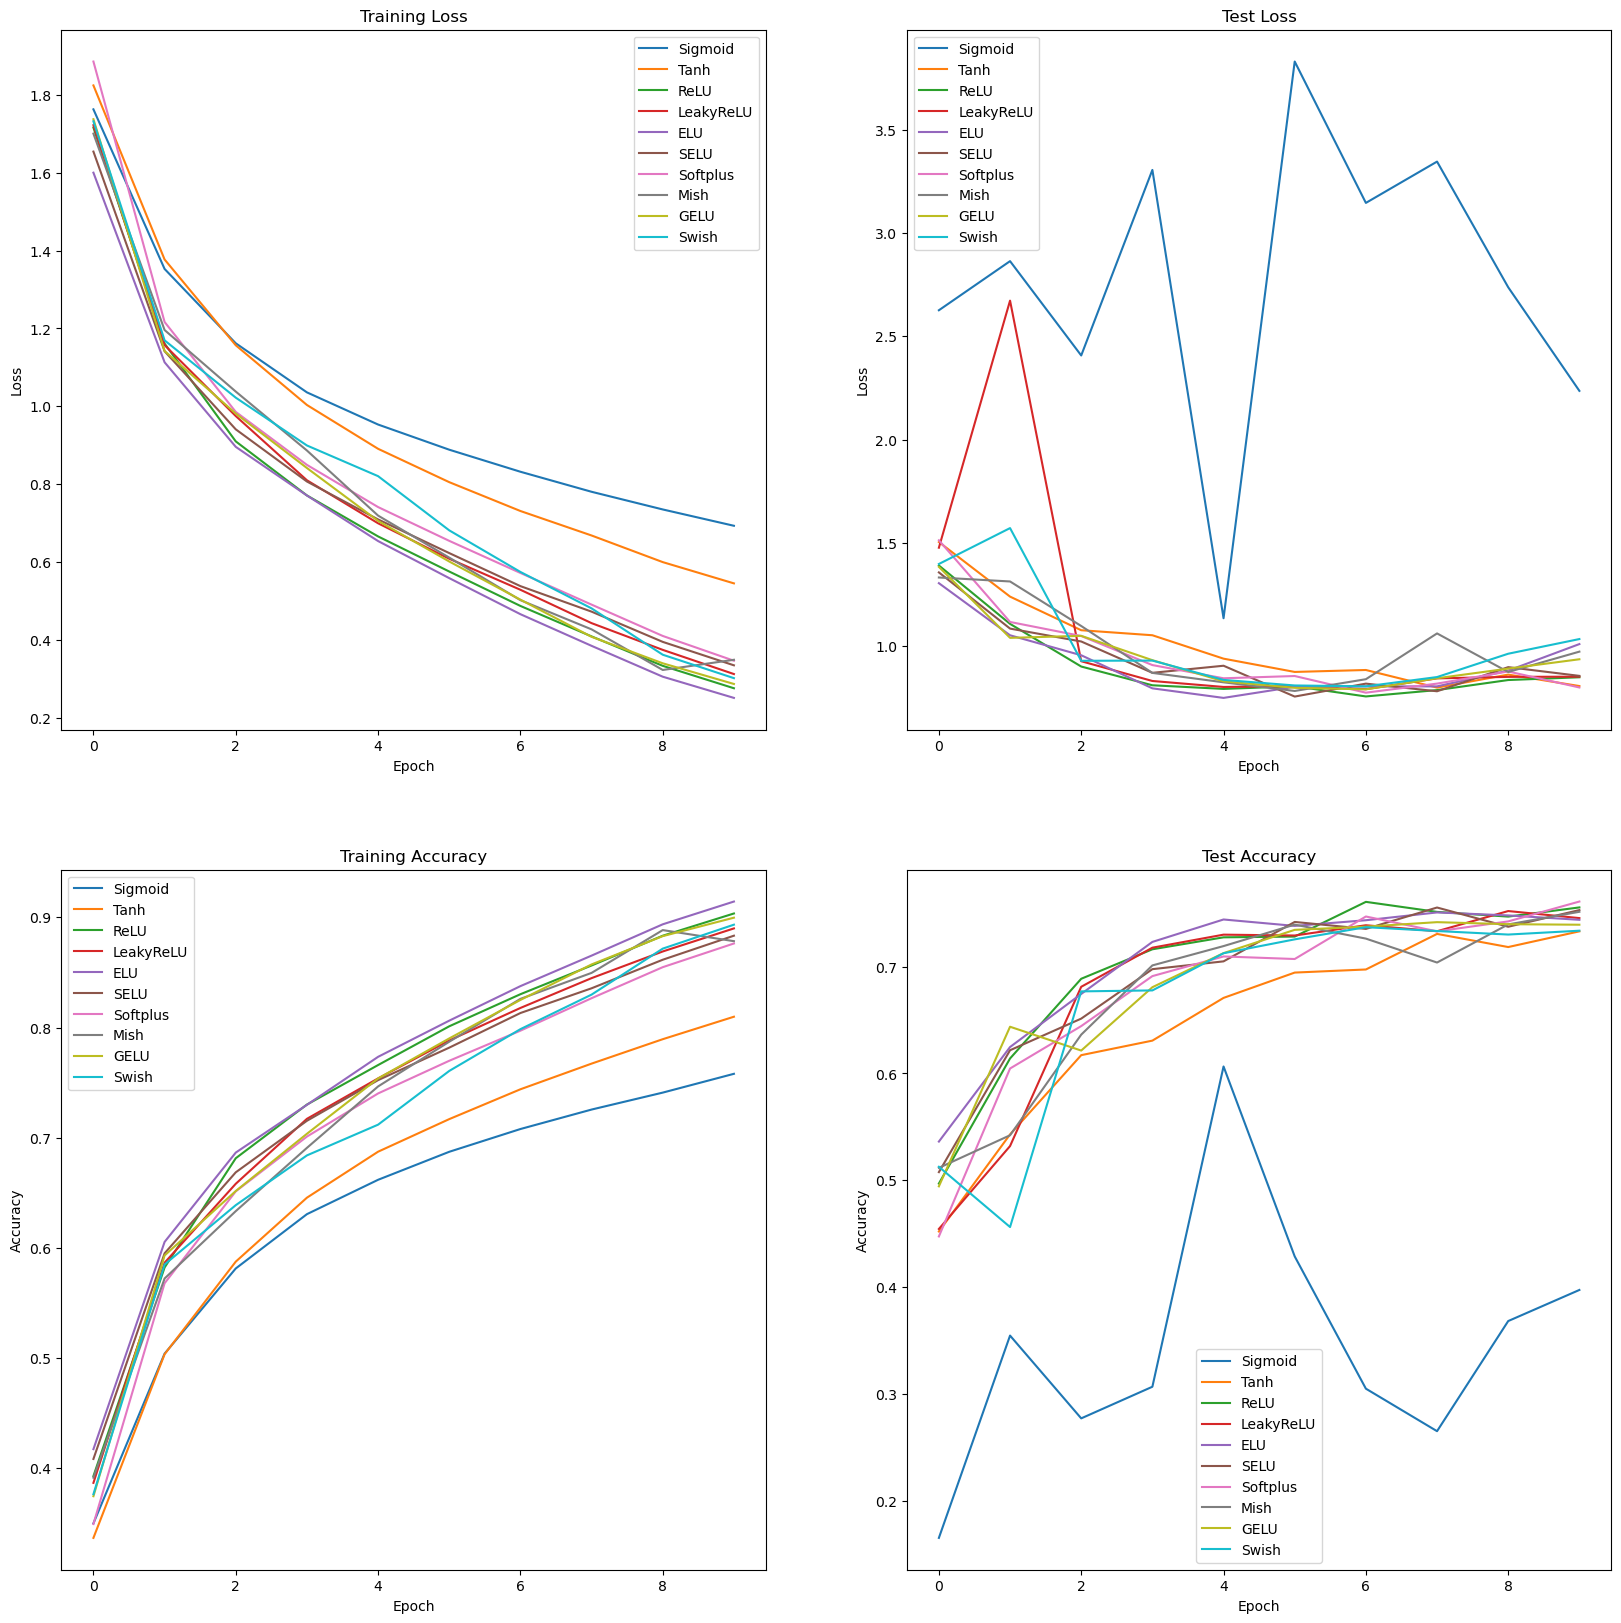

In [11]:

class Swish(nn.Module):
    """Swish activation function

    Args:
        beta (float): beta parameter of the activation function
    """
    def __init__(self, beta=1.0):
        """
        Init method.
        """
        super(Swish, self).__init__()
        self.beta = beta
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        """
        Forward pass of the function.
        """
        return input * self.sigmoid(self.beta * input)

activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.02),
    'ELU': nn.ELU(),
    'SELU': nn.SELU(),
    'Softplus': nn.Softplus(),
    'Mish': nn.Mish(),
    'GELU': nn.GELU(),
    'Swish': Swish()
}

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Instantiate the model with different activation functions
# for activation_name, activation_function in activation_functions.items():
#     resnet_model = ResNet_18(activation=activation_function).to(device)

#     print(f"Running with {activation_name} activation function")
train_and_test(activation_functions, train_loader, test_loader, criterion, device)
